In [1]:
!pip install haversine

# Импорт библиотек и первичная обработка


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from haversine import haversine

In [9]:
data = pd.read_csv('train.csv')

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,N,844
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,N,1001
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,N,1048
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,N,784
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,N,732


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
data.shape

(1021050, 10)

In [ ]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [10]:
data = data.drop('id', axis=1)

# Первичный анализ

In [ ]:
data.corr()['trip_duration']

vendor_id            0.020304
passenger_count      0.008471
pickup_longitude     0.026542
pickup_latitude     -0.029204
dropoff_longitude    0.014678
dropoff_latitude    -0.020677
trip_duration        1.000000
Name: trip_duration, dtype: float64

<AxesSubplot:xlabel='trip_duration', ylabel='Count'>

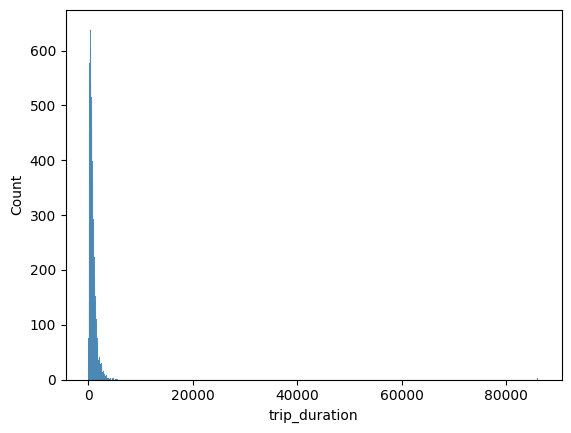

In [ ]:
sns.histplot(data=data[:10000], x='trip_duration')


Заметим, что распределение целевой переменной лог- нормальное , но спойлер нам это никак не помогло улучшить метрику , поэтому оставил как есть


<AxesSubplot:xlabel='trip_duration'>

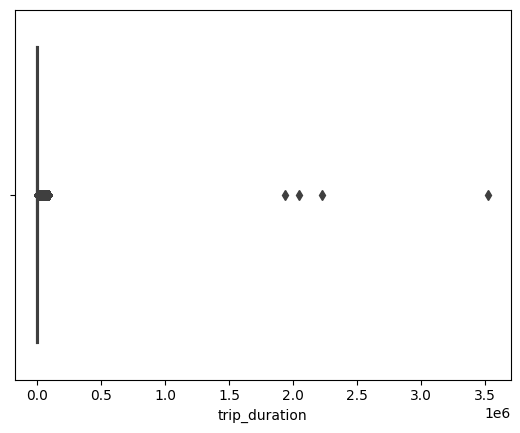

In [ ]:
sns.boxplot(data=data, x='trip_duration')

# Преобразование фичей

Заранее можно сказать что поездка длиной более 2.5 часов скорее всего выброс поэтому будем удалять


In [11]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

data['day'] = data['pickup_datetime'].dt.day_name()

data['pickup_hour'] = data['pickup_datetime'].dt.round('H').dt.hour

data = data.drop(['dropoff_datetime', 'pickup_datetime'], axis=1)

<ipython-input-11-c71836f3e879>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['pickup_hour'] = data['pickup_datetime'].dt.round('H').dt.hour


Оставим только час и день поездки , поскольку год один и тот же час мб поможет в создании других временных признаков а день для определения загруженности ( в рабочий день мб больше) (спойлер не помогло оставил только для создания одного временного признака ниже)

<AxesSubplot:xlabel='dropoff_latitude', ylabel='dropoff_longitude'>

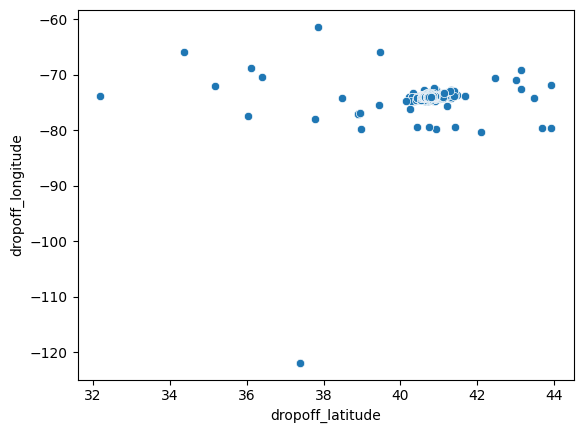

In [ ]:
sns.scatterplot(data=data, x='dropoff_latitude', y='dropoff_longitude')

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

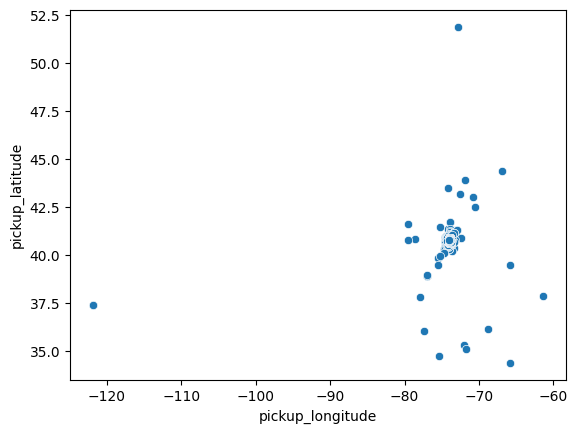

In [ ]:
sns.scatterplot(data=data, x='pickup_longitude', y='pickup_latitude')

Заметим что долгота и широта нью-йорка написана ниже все остальное-выброс

- Широта: приблизительно от 40.477 до 40.917 градусов северной широты.
- Долгота: приблизительно от -74.259 до -73.700 градусов западной долготы.

In [12]:
df = data[(data['dropoff_longitude'] > -74.259) & (data['dropoff_longitude'] < -73.7) &
    (data['pickup_longitude'] > -74.259) & (data['pickup_longitude'] < -73.7) &
    (data['dropoff_latitude'] > 40.477) & (data['dropoff_latitude'] < 40.917) &
     (data['pickup_latitude'] > 40.477) & (data['pickup_latitude'] < 40.917) ]

Удалим выбросы из долготы широты и целевой переменной

In [13]:
df = df.loc[df['trip_duration']<10000]

посчитаем два вида расстояния и посмотрим взаимодействия расстояния со временем

In [14]:
df['haversine_distance'] = df.apply(lambda x: haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'],x['dropoff_longitude'])),axis=1)

df['manhattan_distance'] = (abs(df['pickup_longitude'] - df['dropoff_longitude']) +
                             abs(df['pickup_latitude'] - df['dropoff_latitude']))

df['distance_time_interaction'] = df['haversine_distance'] * df['pickup_hour']


Вычисление азимута только ухудшило метрику (просто оставил для наглядности)

In [ ]:
def calculate_azimuth(lat1, lon1, lat2, lon2):
    delta_lon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    x = np.sin(delta_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon))
    azimuth = np.arctan2(x, y)
    return np.degrees(azimuth)

df['azimuth'] = df.apply(lambda row: calculate_azimuth(row['pickup_latitude'], row['pickup_longitude'],
                                                       row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

Распределим на кластеры по координатам

In [15]:
coords = df[['pickup_latitude', 'pickup_longitude']]
kmeans = KMeans(n_clusters=8, random_state=42).fit(coords)
df['pickup_cluster'] = kmeans.predict(coords)

In [ ]:
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,haversine_distance,manhattan_distance,distance_time_interaction,pickup_cluster,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,store_and_fwd_flag_N,store_and_fwd_flag_Y
0,2,-73.979813,40.752529,-73.982681,40.763680,844,1.263189,0.014019,11.368697,4,0,0,0,0,0,1,0,1,0
1,1,-73.977623,40.746296,-73.968414,40.788933,1001,4.804019,0.051846,81.668318,4,1,0,0,0,0,0,0,1,0
2,1,-73.950699,40.779404,-73.863129,40.768608,1048,7.471099,0.098366,104.595381,2,0,0,0,1,0,0,0,1,0
3,1,-73.984558,40.721802,-73.976753,40.752213,784,3.444874,0.038216,58.562854,0,0,0,0,1,0,0,0,1,0
4,1,-73.967720,40.768742,-73.977173,40.789875,732,2.481066,0.030586,44.659191,4,0,0,0,0,1,0,0,1,0


Еще раз убидимся что после удаления выбросов распределение лог-нормальное

<Axes: xlabel='trip_duration', ylabel='Count'>

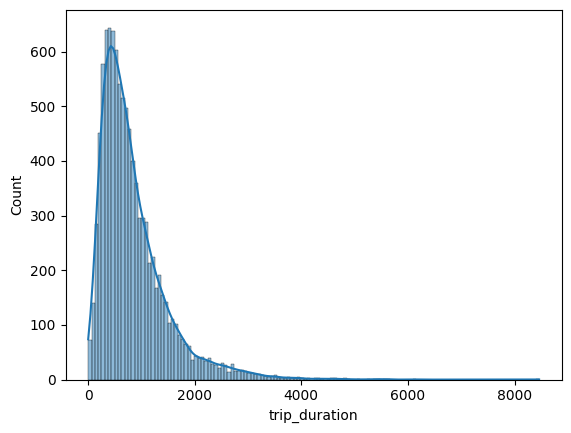

In [16]:
sns.histplot(data=df[:10000], x='trip_duration', kde=True )

# Обучение

Закодируем категориальные признаки и создадим сетку 3x3

In [17]:
# df = df.drop(['pickup_hour', 'store_and_fwd_flag'], axis=1)
df = pd.get_dummies(df, columns=['day', 'vendor_id', 'store_and_fwd_flag'], drop_first=True)

df = df.drop('pickup_hour', axis=1)

In [18]:
# Задаем границы для сетки 3x3 (это пример, на практике можно подобрать другие границы)
longitude_bins = pd.cut(df['pickup_longitude'], bins=3, labels=[0, 1, 2])
latitude_bins = pd.cut(df['pickup_latitude'], bins=3, labels=[0, 1, 2])

# То же самое для dropoff координат
dropoff_longitude_bins = pd.cut(df['dropoff_longitude'], bins=3, labels=[0, 1, 2])
dropoff_latitude_bins = pd.cut(df['dropoff_latitude'], bins=3, labels=[0, 1, 2])

# Создаем две новые фичи, кодирующие, из какой клетки выехало и в какую приехало такси
df['start_cell'] = longitude_bins.astype(str) + "_" + latitude_bins.astype(str)
df['end_cell'] = dropoff_longitude_bins.astype(str) + "_" + dropoff_latitude_bins.astype(str)




Разбиваем выборку

In [22]:
X = df.drop('trip_duration', axis=1)
y = df['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Попробуем два пайплайна с разными скейлерами (гиперпараметры конкретно на таких созданных новых фичах не подбирал  поскольку оперативка стала ложиться это лучшие для прошлого обучения без сетки)

In [23]:
from sklearn.metrics import mean_absolute_error
pipe1 = Pipeline([
    ('Polynom_features', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('model', ElasticNet(alpha=0.06, l1_ratio=0.005))
])

pipe2 = Pipeline([
    ('Polynom_features', PolynomialFeatures(degree=2)),
    ('scaler', MinMaxScaler()),
    ('model', ElasticNet(alpha=0.06, l1_ratio=0.005))
])



In [32]:
pipe1.fit(X_train, y_train)

predict = pipe1.predict(X_test)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.579e+10, tolerance: 3.059e+07
  model = cd_fast.enet_coordinate_descent(


In [33]:
rmse = np.sqrt(mean_squared_error (y_test,predict))

r2 = r2_score(y_test,predict)

print(rmse, r2)

389.41486717211956 0.6497497977049602


In [ ]:
df.corr()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,haversine_distance,manhattan_distance,distance_time_interaction,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,vendor_id_1,vendor_id_2,popular_route
passenger_count,1.000000,0.005069,-0.004469,-0.000103,-0.001983,0.014548,0.011238,0.011161,0.011648,-0.001575,-0.008218,0.020508,0.015205,-0.008765,-0.008281,-0.009158,-0.286719,0.286719,NaN
pickup_longitude,0.005069,1.000000,-0.146173,0.264442,0.037791,0.359986,0.512794,0.528519,0.471264,-0.005328,0.030991,-0.033204,0.001882,-0.001527,0.008934,0.000745,-0.016100,0.016100,NaN
pickup_latitude,-0.004469,-0.146173,1.000000,0.055829,0.432545,-0.233460,-0.315942,-0.322496,-0.268761,0.004372,0.006566,-0.025270,-0.026582,0.009658,0.015796,0.015439,-0.002773,0.002773,NaN
dropoff_longitude,-0.000103,0.264442,0.055829,1.000000,0.118211,0.221384,0.355197,0.362881,0.254964,0.002094,0.008211,-0.017042,0.011702,0.001618,-0.003701,-0.001925,-0.005293,0.005293,NaN
dropoff_latitude,-0.001983,0.037791,0.432545,0.118211,1.000000,-0.188817,-0.176842,-0.170992,-0.141224,0.000316,0.007633,-0.019437,-0.013347,0.002916,0.011146,0.011233,-0.005475,0.005475,NaN
trip_duration,0.014548,0.359986,-0.233460,0.221384,-0.188817,1.000000,0.767328,0.753882,0.671543,0.018383,-0.015685,-0.036643,-0.045322,0.038656,0.011416,0.026889,-0.008226,0.008226,NaN
haversine_distance,0.011238,0.512794,-0.315942,0.355197,-0.176842,0.767328,1.000000,0.992112,0.821662,-0.005437,0.012152,-0.011217,0.027700,-0.002250,-0.009749,-0.009519,-0.008598,0.008598,NaN
manhattan_distance,0.011161,0.528519,-0.322496,0.362881,-0.170992,0.753882,0.992112,1.000000,0.817768,-0.005023,0.013648,-0.012921,0.026305,-0.001969,-0.009341,-0.008965,-0.008711,0.008711,NaN
distance_time_interaction,0.011648,0.471264,-0.268761,0.254964,-0.141224,0.671543,0.821662,0.817768,1.000000,-0.009272,0.019795,-0.031461,-0.000949,0.009400,0.007642,0.006597,-0.011090,0.011090,NaN
day_Friday,-0.001575,-0.005328,0.004372,0.002094,0.000316,0.018383,-0.005437,-0.005023,-0.009272,1.000000,-0.163396,-0.179740,-0.167372,-0.178709,-0.171255,-0.174508,0.000453,-0.000453,NaN


Видим что первый пайп показал себя лучше будем юзать его

In [ ]:
pipe2.fit(X_train, y_train)

predict = pipe2.predict(X_test)

rmse = np.sqrt(mean_squared_error (y_test, predict))

r2 = r2_score(y_test, predict)

In [ ]:
print(rmse, r2)

455.32387872350387 0.5194532806905725


# Пресказания на тесте

In [26]:
test = pd.read_csv('test.csv')

In [ ]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N


In [ ]:
test.shape

(437594, 9)

In [ ]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [27]:
idd = test['id']

test = test.drop('id', axis=1)

test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

test['day'] = test['pickup_datetime'].dt.day_name()

test['pickup_hour'] = test['pickup_datetime'].dt.round('H').dt.hour

test = test.drop( 'pickup_datetime', axis=1)


test['haversine_distance'] = test.apply(lambda x: haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'],x['dropoff_longitude'])),axis=1)

test['manhattan_distance'] = (abs(test['pickup_longitude'] - test['dropoff_longitude']) +
                             abs(test['pickup_latitude'] - test['dropoff_latitude']))

test['distance_time_interaction'] = test['haversine_distance'] * test['pickup_hour']

coords_test = test[['pickup_latitude', 'pickup_longitude']].values

kmeans = KMeans(n_clusters=10, random_state=42).fit(coords_test)
test['pickup_cluster'] = kmeans.predict(coords_test)

test = pd.get_dummies(test, columns=['day', 'vendor_id',  'store_and_fwd_flag'], drop_first=True)

test = test.drop('pickup_hour', axis=1)

# Задаем границы для сетки 3x3 (это пример, на практике можно подобрать другие границы)
longitude_bins = pd.cut(test['pickup_longitude'], bins=3, labels=[0, 1, 2])
latitude_bins = pd.cut(test['pickup_latitude'], bins=3, labels=[0, 1, 2])

# То же самое для dropoff координат
dropoff_longitude_bins = pd.cut(test['dropoff_longitude'], bins=3, labels=[0, 1, 2])
dropoff_latitude_bins = pd.cut(test['dropoff_latitude'], bins=3, labels=[0, 1, 2])

# Создаем две новые фичи, кодирующие, из какой клетки выехало и в какую приехало такси
test['start_cell'] = longitude_bins.astype(str) + "_" + latitude_bins.astype(str)
test['end_cell'] = dropoff_longitude_bins.astype(str) + "_" + dropoff_latitude_bins.astype(str)

# test['route'] = test['start_cell'] + "_" + test['end_cell']


<ipython-input-27-66160f6cbebe>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test['pickup_hour'] = test['pickup_datetime'].dt.round('H').dt.hour


In [ ]:
test

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,haversine_distance,manhattan_distance,distance_time_interaction,pickup_cluster,day_Friday,...,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,store_and_fwd_flag_N,store_and_fwd_flag_Y,start_cell,end_cell,route
0,1,-73.985611,40.735943,-73.980331,40.760468,2.763053,0.029804,22.104427,9,False,...,False,False,False,False,False,True,False,2_2,2_2,2_2_2_2
1,1,-73.978394,40.764351,-73.991623,40.749859,1.959181,0.027721,25.469354,0,False,...,False,False,False,False,False,True,False,2_2,2_2,2_2_2_2
2,5,-73.989059,40.744389,-73.973381,40.748692,1.404774,0.019981,4.214321,9,False,...,False,False,False,False,False,True,False,2_2,2_2,2_2_2_2
3,2,-73.990326,40.731136,-73.991264,40.748917,1.978662,0.018719,33.637262,9,False,...,False,False,False,False,False,True,False,2_2,2_2,2_2_2_2
4,4,-73.789497,40.646675,-73.987137,40.759232,20.837774,0.310196,375.079926,2,False,...,False,False,False,False,False,True,False,2_2,2_2,2_2_2_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437589,2,-73.983505,40.766369,-73.984795,40.785965,2.181693,0.020885,37.088782,0,False,...,False,False,False,False,False,True,False,2_2,2_2,2_2_2_2
437590,1,-73.968147,40.800476,-73.953979,40.787643,1.859725,0.027000,20.456971,6,False,...,False,False,False,False,False,True,False,2_2,2_2,2_2_2_2
437591,5,-74.006210,40.733158,-73.997932,40.722610,1.364599,0.018826,9.552191,8,True,...,False,False,False,False,False,True,False,2_2,2_2,2_2_2_2
437592,2,-73.990089,40.728859,-73.991234,40.765404,4.064745,0.037689,93.489144,8,False,...,False,False,False,False,True,True,False,2_2,2_2,2_2_2_2


In [28]:
predict = pipe1.predict(test)

In [29]:
res = pd.DataFrame({'id' : idd, 'trip_duration' :predict})

In [30]:
res

,id,trip_duration
0,id2793718,553.169605
1,id3485529,359.136206
2,id1816614,137.271981
3,id1050851,470.095690
4,id0140657,3282.285679
...,...,...
437589,id2411525,539.238416
437590,id3782154,236.573559
437591,id0699942,340.128766
437592,id3422152,714.041273


In [31]:
res.to_csv('res_p2.csv', index=False)

# Что не привело к результату

Использование азимута , учитывание времени года- дня, другое кодирование категориальных признаков (labelencoder
 и тд) , отказ от некоторых категориальных , feature_selection

 Вывод: для данного датасета плохо подходит линейная регрессия лучше юзать что-то посильнее